Variance Explained and Networks Analysis Plots

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.cross_decomposition import CCA
from tqdm import tqdm
import seaborn as sns

def sum_correlation_square(A, A_c, return_cross_correlation=False):
    #calculates the variance explained
    sum = 0
    var_explain = np.zeros(A_c.shape[1])
    cross_corr = []
    for i in range(A_c.shape[1]):
        corr = np.array([np.corrcoef(A[:,j], A_c[:,i])[1,0] for j in range(A.shape[1])])
        r2 = corr**2
        sum += np.sum(r2)/A_c.shape[1]
        var_explain[i] = np.sum(r2)/A_c.shape[1]
        cross_corr.append(corr)
    if return_cross_correlation:
        return var_explain, np.vstack(cross_corr)
    else:
        return var_explain

#Load data
grad = np.load('/data/NIMH_scratch/zwallymi/gradients/regressed_spearman_correlations.npy')[:,:9]
beh = np.load('/data/NIMH_scratch/zwallymi/behavioral/NB_regressed_behavioral_pca.npy')
pset = np.load('/data/NIMH_scratch/zwallymi/gradients_and_behavior/10kperm/10kperm_pset.npy')
abcd_gradients = np.load('/data/NIMH_scratch/zwallymi/gradients/group_files/group_site_regressed_gradients.npy')
hcp_gradients = np.load('/data/NIMH_scratch/zwallymi/gradients/group_files/hcp_gradients.npy')

### Variance Explained Analysis Preparation ###

#obtain observed variance values
n_components = 9
U, V = CCA(n_components=n_components).fit_transform(grad, beh)
observed_grad_var_explain = sum_correlation_square(grad, U)
observed_beh_var_explain = sum_correlation_square(beh, V)

#create null distribution for variance
cd_grad_variance_explain = []
cd_beh_variance_explain = []
for i in tqdm(range(1,10001)):
    index = pset[i,:]-1
    U, V = CCA(n_components=n_components).fit_transform(grad, beh[index])

    grad_var_explain = sum_correlation_square(grad, U)
    cd_grad_variance_explain.append(grad_var_explain)

    beh_var_explain = sum_correlation_square(beh[index], V)
    cd_beh_variance_explain.append(beh_var_explain)

cd_grad_variance_explain = np.vstack(cd_grad_variance_explain)
cd_beh_variance_explain = np.vstack(cd_beh_variance_explain)

#calculate percentiles for creating confidence interval
ci_grad_lower_list = np.percentile(cd_grad_variance_explain, 5, axis=0)
ci_grad_upper_list = np.percentile(cd_grad_variance_explain, 95, axis=0)
ci_beh_lower_list = np.percentile(cd_beh_variance_explain, 5, axis=0)
ci_beh_upper_list = np.percentile(cd_beh_variance_explain, 95, axis=0)


### Network Analysis Preparation ###


#put all gradients into one dataframe and load parcellation networks
all_gradients = pd.DataFrame({'ABCD 1': abcd_gradients[:,0] * -1, 'ABCD 2': abcd_gradients[:,1] * -1, 'HCP 1': hcp_gradients[:,0], 'HCP 2': hcp_gradients[:,1]})
with open('/data/MLDSST/parcellations/schaefer/HCP/fslr32k/cifti/Schaefer2018_400Parcels_7Networks_order_info.txt') as file:
    info_text = [line.strip() for line in file]

#categorize regions into networks based on Yeo 7 networks
networks = {}
counter = 0
for i, line in enumerate(info_text) :
    if i % 2 == 0 :
        counter += 1
        if 'Vis' in line :
            temp = 'Vis'
        elif 'SomMot' in line :
            temp = 'SomMot'
        elif 'DorsAttn' in line :
            temp = 'DorsAttn'
        elif 'SalVentAttn' in line :
            temp = 'SalVentAttn'
        elif 'Limbic' in line :
            temp = 'Limbic'
        elif 'Cont' in line:
            temp = 'Cont'
        elif 'Default' in line :
            temp = 'Default'
        networks.update({counter: temp})
        
def sort_values(gradient) :
    vis = []
    sommot = []
    dorsattn = []
    salventattn = []
    limbic = []
    cont = []
    default = []
    for i, value in enumerate(gradient) :
        if networks.get(i) == 'Vis' :
            vis.append(value)
        elif networks.get(i) == 'SomMot' :
            sommot.append(value)
        elif networks.get(i) == 'DorsAttn' :
            dorsattn.append(value)
        elif networks.get(i) == 'SalVentAttn' :
            salventattn.append(value)
        elif networks.get(i) == 'Limbic' :
            limbic.append(value)
        elif networks.get(i) == 'Cont' :
            cont.append(value)
        elif networks.get(i) == 'Default' :
            default.append(value)
    return [vis, sommot, dorsattn, salventattn, limbic, cont, default]

nets_dict = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal/Ventral Attn', 'Limbic', 'Control', 'Default']
abcd1_nets = pd.DataFrame(sort_values(abcd_gradients[:, 0] * -1), index=nets_dict).T
abcd2_nets = pd.DataFrame(sort_values(abcd_gradients[:, 1] * -1), index=nets_dict).T
hcp1_nets = pd.DataFrame(sort_values(hcp_gradients[:, 0]), index=nets_dict).T
hcp2_nets = pd.DataFrame(sort_values(hcp_gradients[:, 1]), index=nets_dict).T

#create colors for Yeo 7 networks
cols7 = ((120/255, 18/255, 134/255, 1),
         (70/255, 130/255, 180/255, 1),
         ( 0, 118/255, 14/255, 1),
         (196/255, 58/255, 250/255, 1),
         (220/255, 248/255, 164/255),
         (230/255, 148/255, 34/255, 1),
         (205/255, 62/255, 78/255, 1))

#set seaborn plot specifications
sns.set_context('poster', font_scale=1.8)
sns.axes_style("white")
sns.set_style("white")
sns.set_palette(cols7, n_colors=7)

Variance Explained Plots

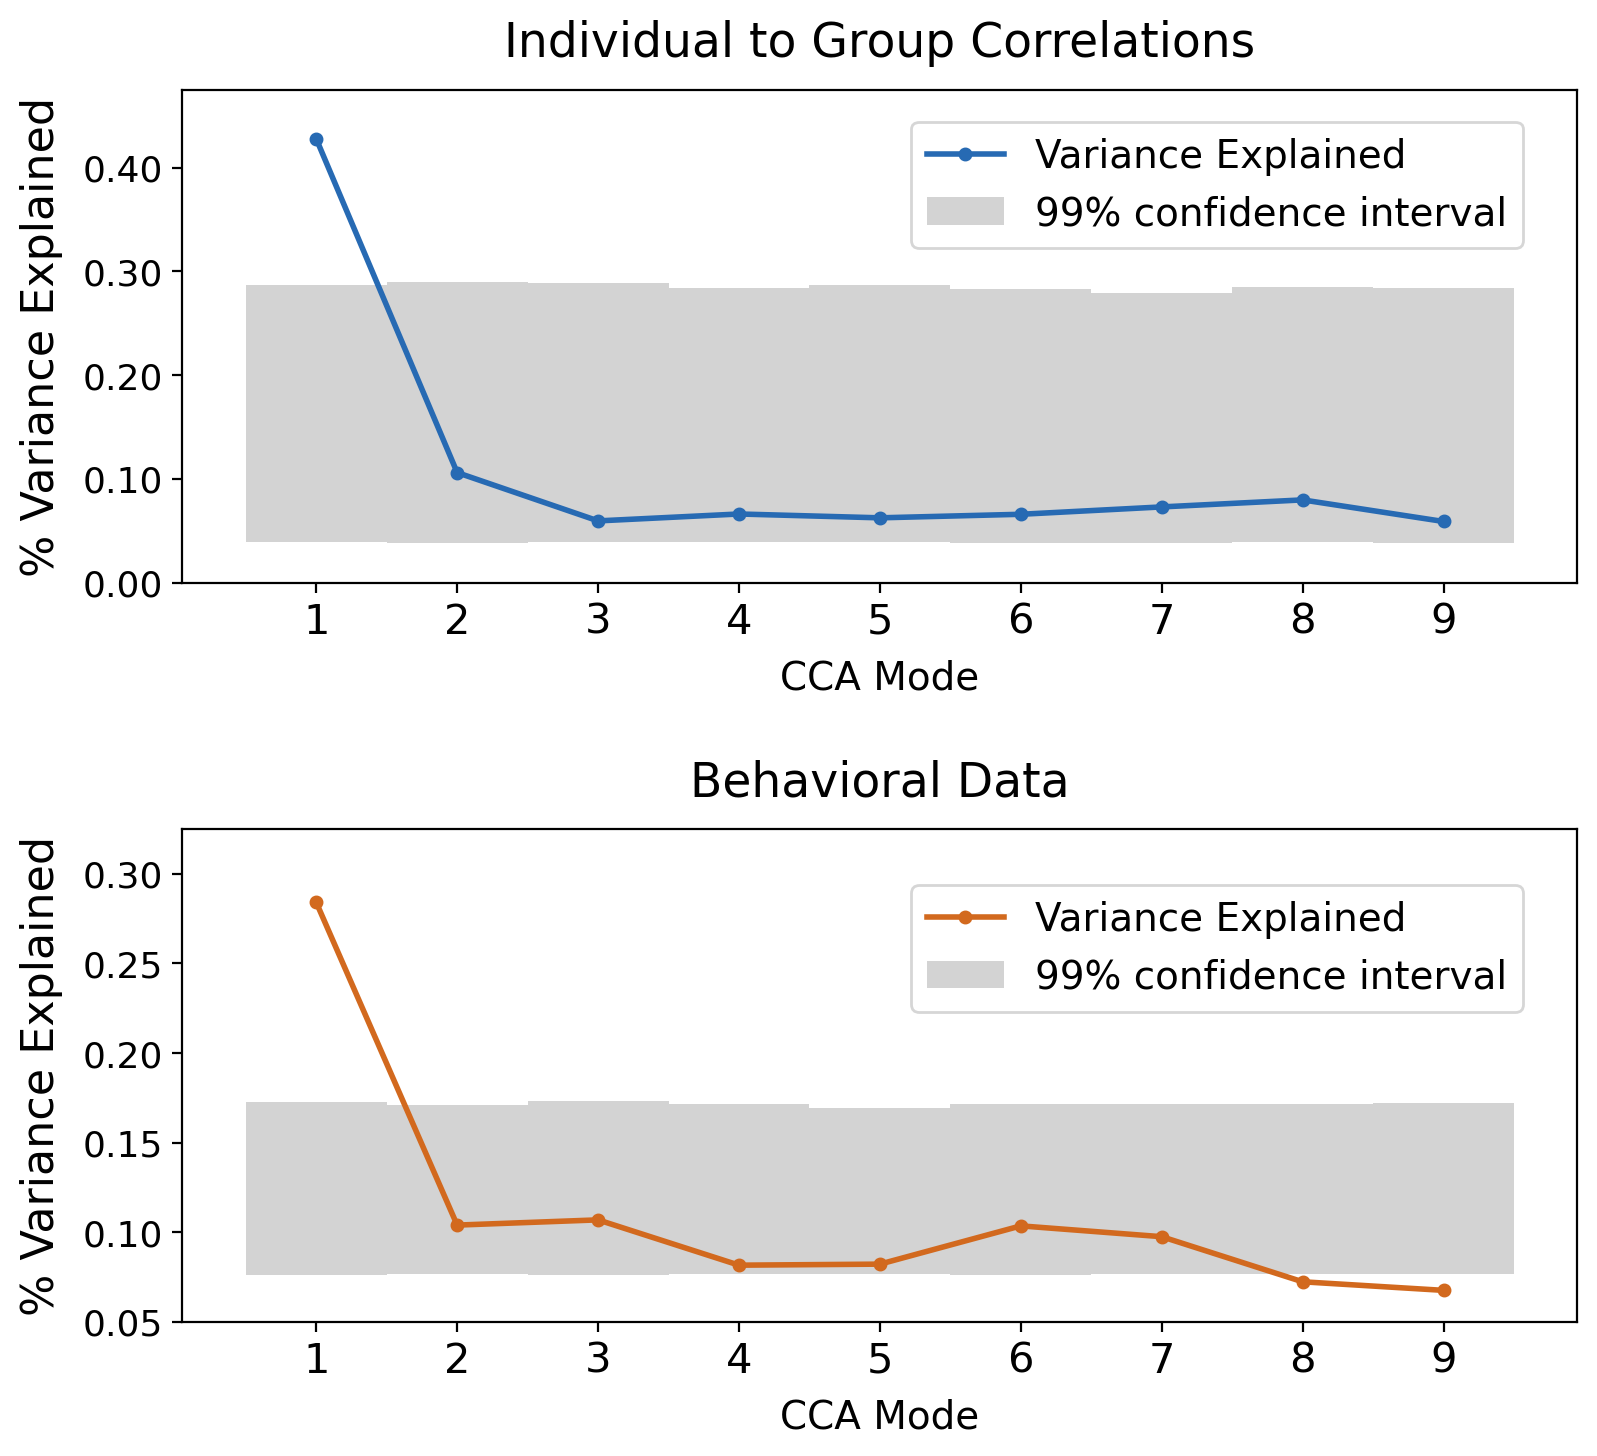

In [ ]:
fig, ax = plt.subplots(figsize=(9,8), nrows=2, dpi=200)
plt.rc('ytick', labelsize=13) 

#create line plots and add confidence interval
ax[0].plot(observed_grad_var_explain, marker='.', linewidth=2, markersize=8, color='xkcd:mid blue')
ax[1].plot(observed_beh_var_explain, marker='.', linewidth=2, markersize=8, color='chocolate')
for i in range(9) :
        ax[0].add_patch(Rectangle((i-0.5, ci_grad_lower_list[i]), 1, ci_grad_upper_list[i]-ci_grad_lower_list[i], linewidth=1, facecolor='lightgray'))
        ax[1].add_patch(Rectangle((i-0.5, ci_beh_lower_list[i]), 1, ci_beh_upper_list[i]-ci_beh_lower_list[i], linewidth=1, facecolor='lightgray'))

#add titles, modify axes and ticks    
for j in range(2):
    ax[j].set_ylabel('% Variance Explained', size=16, labelpad=7)
    ax[j].set_xticks(ticks=range(0,9), labels=range(1,10), size=15)
    ax[j].set_xlabel('CCA Mode', size=14, labelpad=6)
ax[0].legend(('Variance Explained', '99% confidence interval'), fontsize=14, bbox_to_anchor=(0.975, 0.975))
ax[1].legend(('Variance Explained', '99% confidence interval'), fontsize=14, bbox_to_anchor=(0.975, 0.925))
ax[0].set_title('Individual to Group Correlations', size=17, pad=12)
ax[1].set_title('Behavioral Data', size=17, pad=12)
ax[0].set_ybound(0, 0.475)
ax[1].set_ybound(0.05, 0.325)
ax[0].set_yticks(ticks=(0, 0.1, 0.2, 0.3, 0.4), labels=('0.00', '0.10', '0.20', '0.30', '0.40'), size=13)
ax[1].set_yticks(ticks=(0.05, 0.1, 0.15, 0.2, 0.25, 0.3), labels=('0.05', '0.10', '0.15', '0.20', '0.25', '0.30'), size=13)
fig.subplots_adjust(hspace=0.5)

Network Analysis Plots

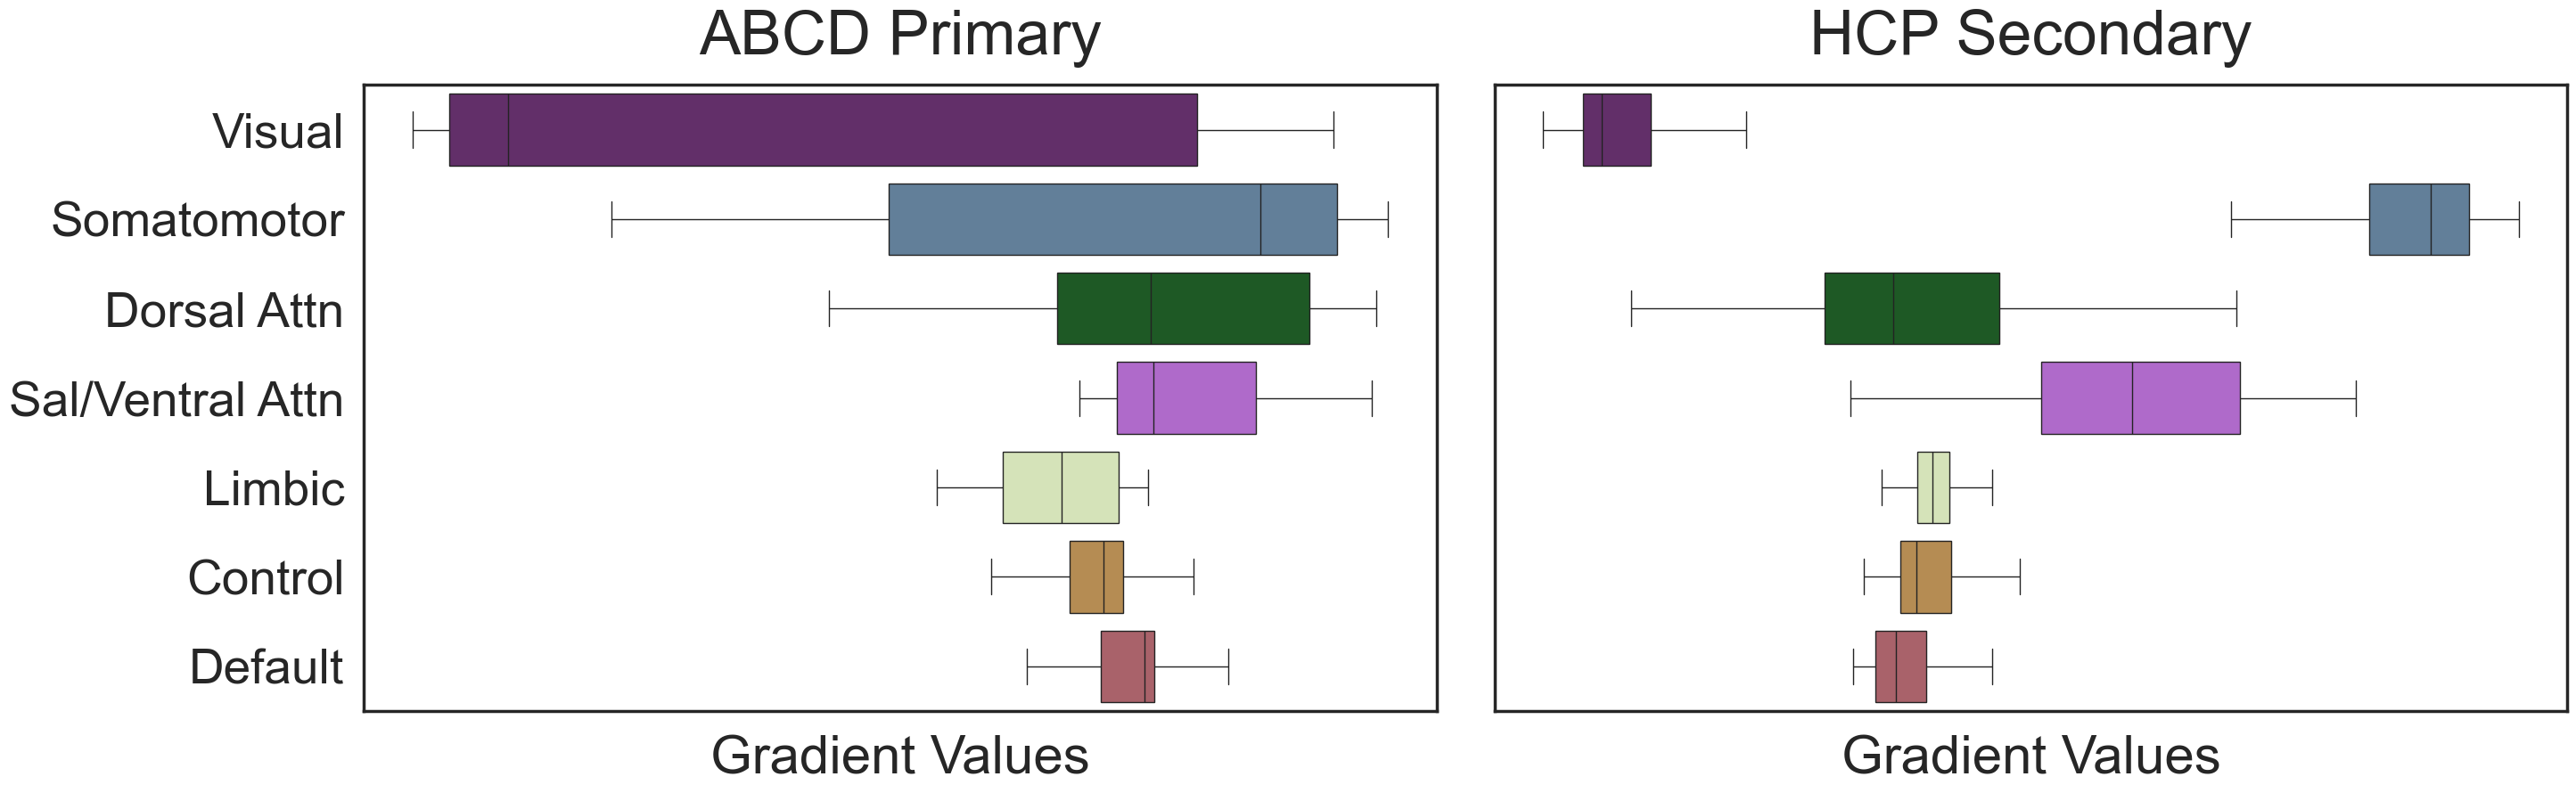

In [5]:
#ABCD Primary and HCP Secondary
fig1, axes1 = plt.subplots(1, 2, figsize=(30, 10), sharey=True)
sns.boxplot(data=abcd1_nets, ax=axes1[0], saturation=0.5, orient='h', showfliers=False)
sns.boxplot(data=hcp2_nets, ax=axes1[1], saturation=0.5, orient='h', showfliers=False)

#set titles, labels, and ticks
axes1[0].set_title('ABCD Primary', pad=25, fontsize=50)
axes1[1].set_title('HCP Secondary', pad=25, fontsize=50)
axes1[0].set_xticklabels('')
axes1[1].set_xticklabels('')
axes1[0].set_xlabel('Gradient Values')
axes1[1].set_xlabel('Gradient Values')
fig1.tight_layout()

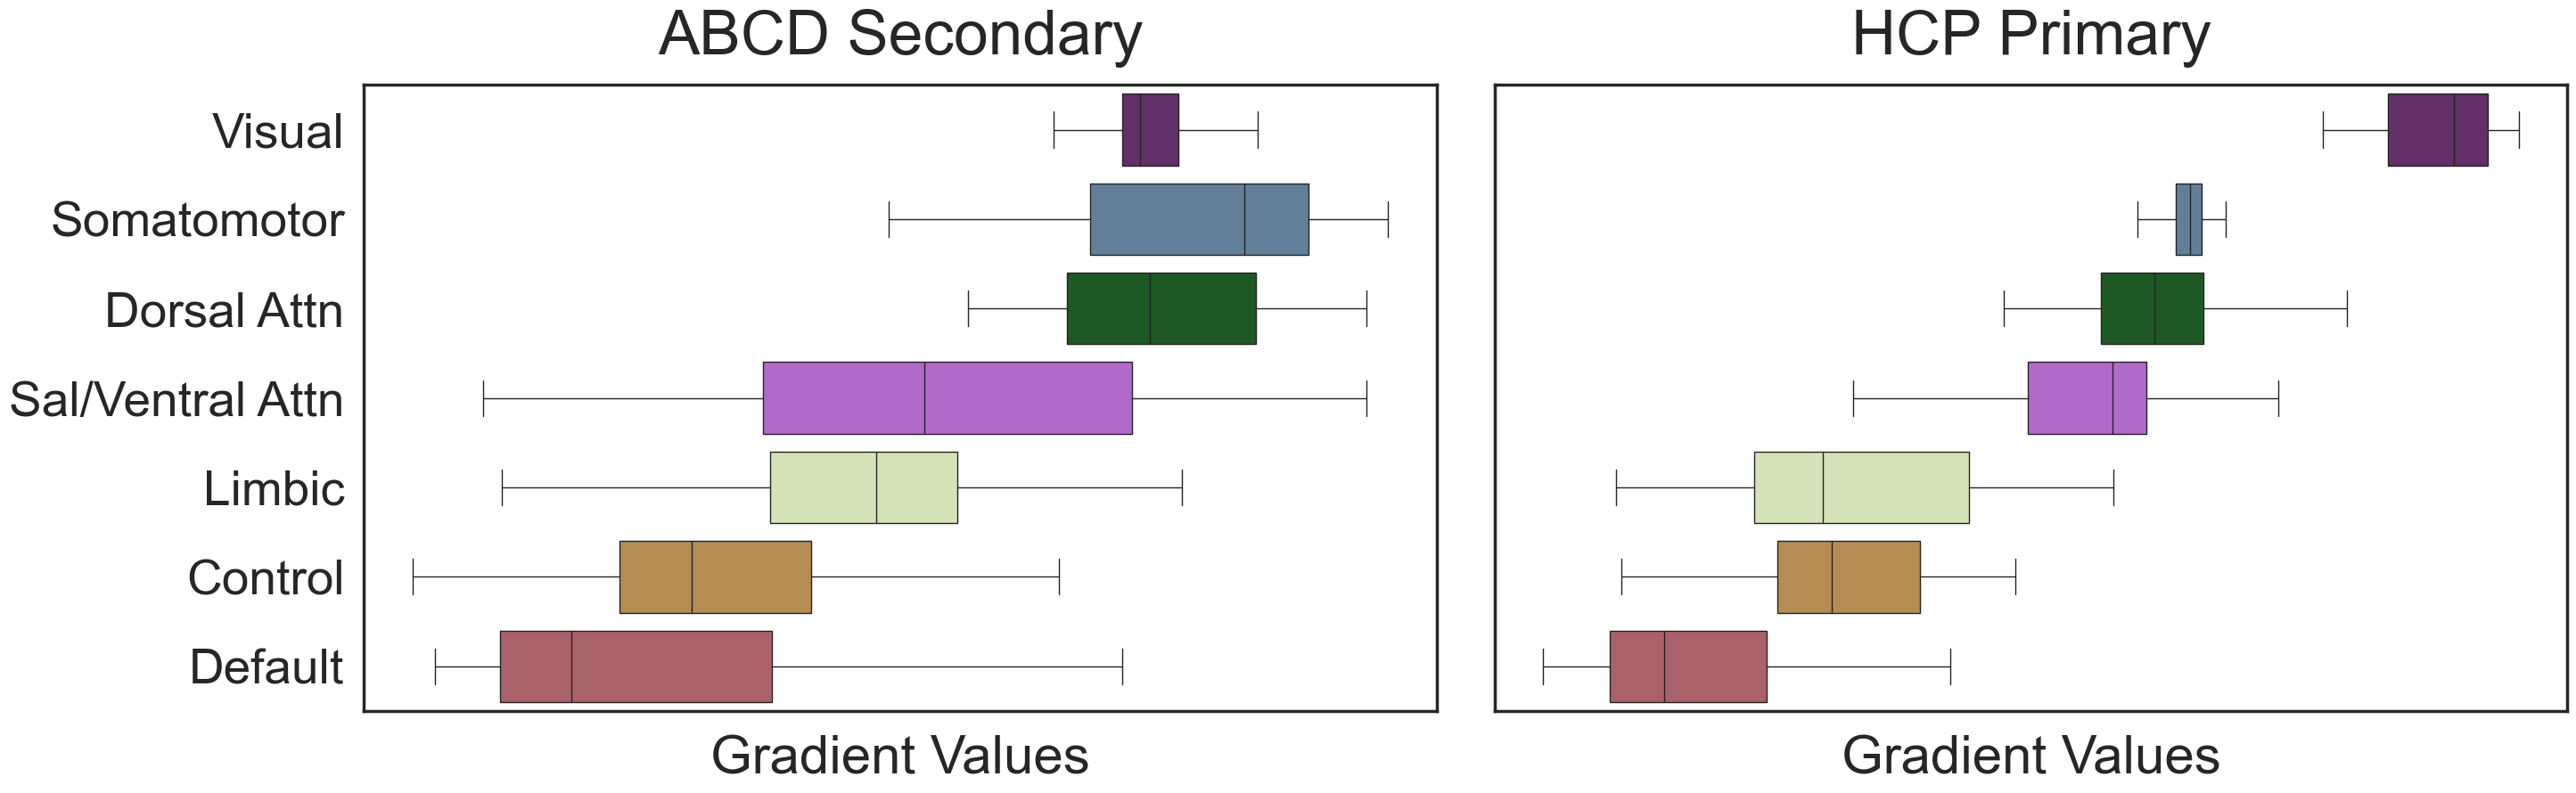

In [6]:
#ABCD Secondary and HCP Primary
fig2, axes2 = plt.subplots(1, 2, figsize=(30, 10), sharey=True)

sns.boxplot(data=abcd2_nets, ax=axes2[0], saturation=0.5, orient='h', showfliers=False)
sns.boxplot(data=hcp1_nets, ax=axes2[1], saturation=0.5, orient='h', showfliers=False)

#set titles, labels, and ticks
axes2[0].set_title('ABCD Secondary', pad=25, fontsize=50)
axes2[1].set_title('HCP Primary', pad=25, fontsize=50)
axes2[0].set_xticklabels('')
axes2[1].set_xticklabels('')
axes2[0].set_xlabel('Gradient Values')
axes2[1].set_xlabel('Gradient Values')
fig2.tight_layout()